In [2]:
!git clone https://github.com/imostafizur/CSE498R.git

fatal: destination path 'CSE498R' already exists and is not an empty directory.


## Resnet50 Model for Malaria Detection

In [3]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
image = ('cell_images')

In [5]:
#Count the number of images in each folder
import os
print(len(os.listdir('cell_images/Parasitized')))
print(len(os.listdir('cell_images/Uninfected')))

13780
13780


In [6]:
#Create a dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


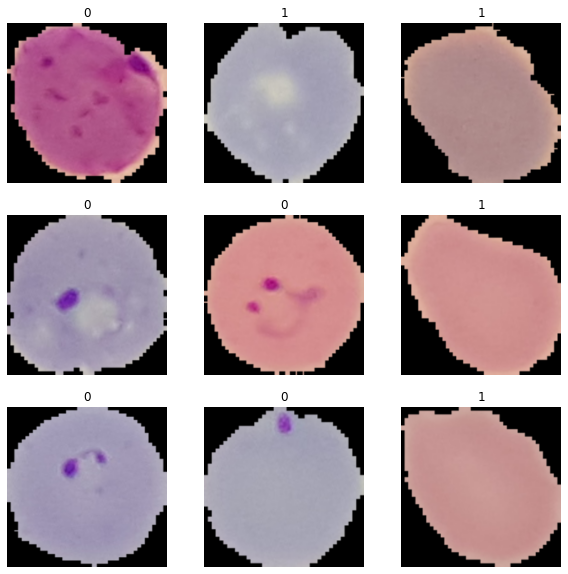

In [7]:
#Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
#Split the data into training and validation sets
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [9]:
#Normalize the data
normalization_layer = preprocessing.Rescaling(1./255)

normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.8420803


In [10]:
#Create the model ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model

base_model = ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False

#Add a classification head
inputs = keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

#Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)


94781440/94765736 [==============================] - 0s 0us/step


In [11]:
#Train the model
history = model.fit(
    dataset, epochs=10, validation_data=val_dataset,
)

Epoch 1/10
689/689 [==============================] - 128s 164ms/step - loss: 0.2677 - binary_accuracy: 0.8867 - val_loss: 0.1938 - val_binary_accuracy: 0.9236
Epoch 2/10
689/689 [==============================] - 118s 171ms/step - loss: 0.1940 - binary_accuracy: 0.9251 - val_loss: 0.1780 - val_binary_accuracy: 0.9341
Epoch 3/10
689/689 [==============================] - 117s 169ms/step - loss: 0.1823 - binary_accuracy: 0.9301 - val_loss: 0.1701 - val_binary_accuracy: 0.9340
Epoch 4/10
689/689 [==============================] - 117s 170ms/step - loss: 0.1724 - binary_accuracy: 0.9359 - val_loss: 0.1774 - val_binary_accuracy: 0.9345
Epoch 5/10
689/689 [==============================] - 117s 169ms/step - loss: 0.1682 - binary_accuracy: 0.9360 - val_loss: 0.1642 - val_binary_accuracy: 0.9390
Epoch 6/10
689/689 [==============================] - 117s 170ms/step - loss: 0.1649 - binary_accuracy: 0.9361 - val_loss: 0.1567 - val_binary_accuracy: 0.9394
Epoch 7/10
689/689 [====================

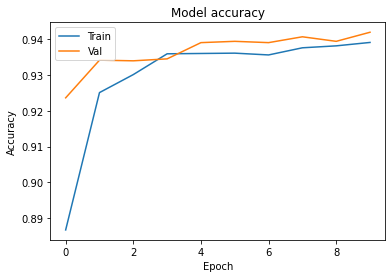

In [12]:
#Plot the training and validation accuracy/loss
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

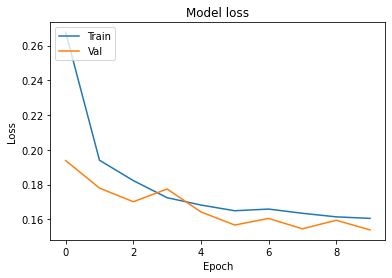

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [16]:
#Predict the model
predictions = model.predict(val_dataset)
predictions = np.round(predictions)
predictions = predictions.astype(int)



In [15]:
#Save the model
model.save('malaria_resnet50.h5')